# Example_7_4

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Calculate again the solution of Example 6.1 but this time as an ADMM distributed model splitting the samples into four nodes.

$$
\underset{{\bf{w}}}{\min}f\left({\bf{w}}\right)\rightarrow\begin{cases}
\begin{array}{c}
\underset{{\bf{w}}}{\,\min}\frac{1}{4}\overset{4}{\underset{i=1}{\sum}}\left({\bf{x}}_{i}^{T}{\bf{w}}_{i}-{\bf{y}}_{i}\right)^{2}+\frac{\lambda}{2}\left\Vert {\bf{z}}\right\Vert _{2}^{2}\\
s.t.\, {\bf{x}}_{i}-{\bf{z}}=0\,\,\,\,\,i=1,\cdots,4
\end{array}\end{cases}
$$

The Lagrangian in this case is
$$
L_{\rho}\left({\bf{w}}_{1},{\bf{w}}_{2},{\bf{w}}_{3},{\bf{w}}_{4},{\bf{\beta}}_{1},{\bf{\beta}}_{2},{\bf{\beta}}_{3},{\bf{\beta}}_{4},{\bf{z}}\right)=\frac{1}{4}\overset{4}{\underset{i=1}{\sum}}\left({\bf{x}}_{i}^{T}{\bf{w}}_{i}-b_{i}\right)^{2}+\frac{\lambda}{2}\left\Vert {\bf{z}}\right\Vert _{2}^{2}+\overset{4}{\underset{i=1}{\sum}}{\bf{\beta}}_{i}^{T}\left({\bf{w}}_{i}-z\right)+\frac{\rho}{2}\overset{4}{\underset{i=1}{\sum}}\left\Vert {\bf{w}}_{i}-{\bf{z}}\right\Vert _{2}^{2}
$$

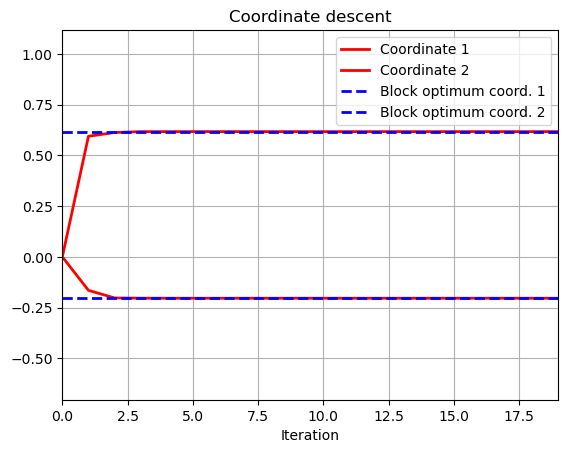

In [28]:
nf=2           # Number of features
ns=4           # Number of samples
lamb=0.1       # Regularizer
ro=0.2         # Quadratic term
niter=20       # Number of iterations
X=np.random.randn(ns,nf) # Samples
y=np.random.randn(ns,1)   # Samples
# Direct implementation
w_opt=np.linalg.inv(X.T@X+2*lamb*np.eye(nf))@(X.T@y)


# Coordinate descent
w0_1=np.zeros(niter);
w0_2=np.zeros(niter);
for k in range(1,niter):
    w0_1[k]=((X[:,0].T@y-X[:,0].T@X[:,1]*w0_2[k-1])/(2*lamb+X[:,0].T@X[:,0]))[0]
    w0_2[k]=((X[:,1].T@y-X[:,0].T@X[:,1]*w0_1[k-1])/(2*lamb+X[:,1].T@X[:,1]))[0]

                                                      
t = range(niter)
plt.plot(t,w0_1,color='r', linewidth = 2)
plt.plot(t,w0_2,color='r', linewidth = 2)
plt.plot(t,np.ones(niter)*w_opt[0],color = 'b', linestyle = 'dashed',linewidth = 2)
plt.plot(t,np.ones(niter)*w_opt[1],color = 'b', linestyle = 'dashed',linewidth = 2)
plt.grid()
plt.xlim([0, niter-1])
plt.ylim([np.min(w_opt)-.5, np.max(w_opt)+.5])
plt.title('Coordinate descent')
plt.xlabel('Iteration')
plt.legend(['Coordinate 1','Coordinate 2','Block optimum coord. 1','Block optimum coord. 2'])
plt.show()

In [110]:
# ADMM implementation
w1=np.zeros((nf,niter))
beta1=np.zeros((nf,niter))
z1=np.zeros((nf,niter))
for k in range(1,niter):
    w1[:,k]=np.linalg.inv(X.T@X+2*ro*np.eye(nf))@((X.T@y).flatten()+2*ro*z1[:,k-1]-2*beta1[:,k-1]);
    z1[:,k]=(beta1[:,k-1]+ro*w1[:,k])/(lamb+ro)
    beta1[:,k]=beta1[:,k-1]+ro*(w1[:,k]-z1[:,k])                                                                                                                                                      

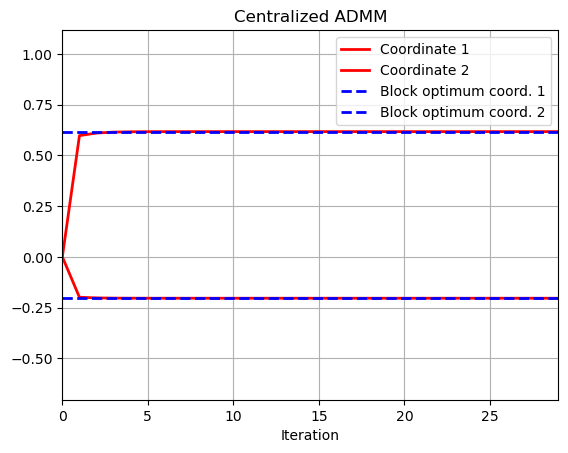

In [111]:
t = range(niter)
plt.plot(t,w1[0,:],color='r',linewidth = 2)
plt.plot(t,w1[1,:],color='r',linewidth = 2)
plt.plot(t,np.ones(niter)*w_opt[0],color = 'b', linestyle = 'dashed',linewidth = 2)
plt.plot(t,np.ones(niter)*w_opt[1],color = 'b', linestyle = 'dashed',linewidth = 2)
plt.grid()
plt.xlim([0, niter-1])
plt.ylim([np.min(w_opt)-.5, np.max(w_opt)+.5])
plt.title('Centralized ADMM')
plt.xlabel('Iteration')
plt.legend(['Coordinate 1','Coordinate 2','Block optimum coord. 1','Block optimum coord. 2'])
plt.show()

In [135]:
# Distributed ADMM splitting samples
niter=30
w2_1=np.zeros((nf,niter)); w2_2=w2_1.copy(); w2_3=w2_1.copy(); w2_4=w2_1.copy()
beta2_1=np.zeros((nf,niter)); beta2_2=beta2_1.copy(); beta2_3=beta2_1.copy(); beta2_4=beta2_1.copy()
z2=np.zeros((nf,niter))
I = np.eye(nf)
A1 = np.linalg.inv((X[0,:].reshape(1,-1)).T@(X[0,:].reshape(1,-1))+2*ro*I)
A2 = np.linalg.inv((X[1,:].reshape(1,-1)).T@(X[1,:].reshape(1,-1))+2*ro*I)
A3 = np.linalg.inv((X[2,:].reshape(1,-1)).T@(X[2,:].reshape(1,-1))+2*ro*I)
A4 = np.linalg.inv((X[3,:].reshape(1,-1)).T@(X[3,:].reshape(1,-1))+2*ro*I)
b1 = X[0,:]*y[0]
b2 = X[1,:]*y[1]
b3 = X[2,:]*y[2]
b4 = X[3,:]*y[3]

for k in range(1,niter):
    w2_1[:,k]=A1@(b1+2*ro*z2[:,k-1]-2*beta2_1[:,k-1])
    w2_2[:,k]=A2@(b2+2*ro*z2[:,k-1]-2*beta2_2[:,k-1])
    w2_3[:,k]=A3@(b3+2*ro*z2[:,k-1]-2*beta2_3[:,k-1])
    w2_4[:,k]=A4@(b4+2*ro*z2[:,k-1]-2*beta2_4[:,k-1])
    sum_beta=beta2_1[:,k-1]+beta2_2[:,k-1]+beta2_3[:,k-1]+beta2_4[:,k-1]
    sum_w=w2_1[:,k]+w2_2[:,k]+w2_3[:,k]+w2_4[:,k]
    z2[:,k]=(sum_beta+ro*sum_w)/(lamb+4*ro)
    beta2_1[:,k]=beta2_1[:,k-1]+ro*(w2_1[:,k]-z2[:,k])
    beta2_2[:,k]=beta2_2[:,k-1]+ro*(w2_2[:,k]-z2[:,k])
    beta2_3[:,k]=beta2_3[:,k-1]+ro*(w2_3[:,k]-z2[:,k])
    beta2_4[:,k]=beta2_4[:,k-1]+ro*(w2_4[:,k]-z2[:,k])

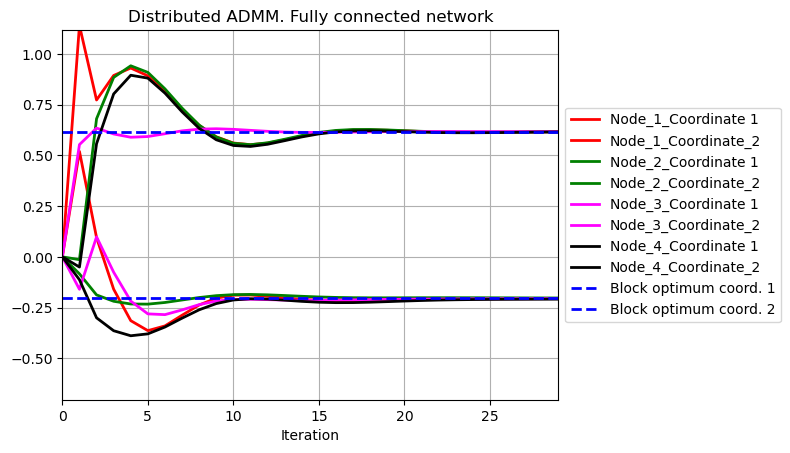

In [138]:
t = range(niter)
plt.plot(t,w2_1[0,:],color='r',linewidth = 2)
plt.plot(t,w2_1[1,:],color='r',linewidth = 2)
plt.plot(t,w2_2[0,:],color='g',linewidth = 2)
plt.plot(t,w2_2[1,:],color='g',linewidth = 2)
plt.plot(t,w2_3[0,:],color='magenta',linewidth = 2)
plt.plot(t,w2_3[1,:],color='magenta',linewidth = 2)
plt.plot(t,w2_4[0,:],color='black',linewidth = 2)
plt.plot(t,w2_4[1,:],color='black',linewidth = 2)
plt.plot(t,np.ones(niter)*w_opt[0],color = 'b', linestyle = 'dashed',linewidth = 2)
plt.plot(t,np.ones(niter)*w_opt[1],color = 'b', linestyle = 'dashed',linewidth = 2)
plt.grid()
plt.xlim([0, niter-1])
plt.ylim([np.min(w_opt)-.5, np.max(w_opt)+.5])
plt.title('Distributed ADMM. Fully connected network')
plt.xlabel('Iteration')
plt.legend(['Node_1_Coordinate 1','Node_1_Coordinate_2','Node_2_Coordinate 1','Node_2_Coordinate_2','Node_3_Coordinate 1','Node_3_Coordinate_2','Node_4_Coordinate 1','Node_4_Coordinate_2','Block optimum coord. 1','Block optimum coord. 2'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()